# Segmentacion mediante crecimiento por regiones
#### Grupo 1: Mariana Nakagawa,María Pardo y Gema Perez.

Índice de los pasos a seguir:
1. Preparación de imágenes 
2. Implementación algoritmo: crecimiento por regiones
3. Resultados finales
4. Referencias
5. Autoría

## 1. Preparación de las imágenes

##### Importación de librerías

En esta sección vamos a proceder a visualizar las imágenes que hemos obtenido del repositorio de bases de datos Open Neuro, para poder evaluar los resultados de filtrado que debemos realizar. 

En primer lugar, cargaremos las imágenes con las que testearemos nuestro código. Se trata de imágenes de fMRI.

In [1]:
import os
import numpy as np
import nibabel as nib #nos permite leer las imagenes
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
from nilearn import plotting
import modules

In [2]:
img1 = nib.load(r'\Users\Maria\Desktop\data\sub-01\anat\sub-01_T1w.nii.gz')
img2 = nib.load(r"\Users\Maria\Desktop\data\sub-17\anat\sub-17_T1w.nii.gz")
img3 = nib.load(r"\Users\Maria\Desktop\data\sub-26\anat\sub-26_T1w.nii.gz")
img4 = nib.load(r"\Users\Maria\Desktop\data\sub-31\anat\sub-31_T1w.nii.gz")
img5 = nib.load(r"\Users\Maria\Desktop\data\sub-13\anat\sub-13_T1w.nii.gz")
img6 = nib.load(r"\Users\Maria\Desktop\data\sub-15\anat\sub-15_T1w.nii.gz")

In [3]:
data = img1.get_fdata()  

In [4]:
print(data.shape)

(176, 256, 256)


In [5]:
print(data.dtype, img1.get_data_dtype())

float64 float32


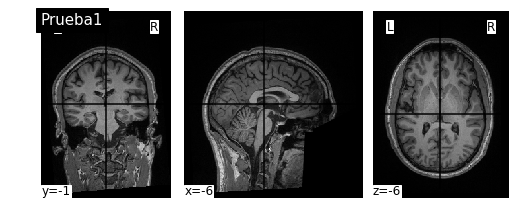

In [6]:
plotting.plot_img(img1, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()     

Para poder realizar el algoritmo, vamos a transformar los datos al formato array, y tras ello guardaremos un único corte (que hemos elegido de manera aleatoria) al que realizaremos la adición. 
​
> En caso de querer disminuir el tiempo de ejecución descomente una de las líneas para disminuír el tamaño de las imágenes y por ende, el número de píxeles a analizar.<pre><code>a = np.array(skimage.transform.resize(img1.dataobj, (50,70)))
a = np.array(skimage.transform.rescale(img.dataobj,0.3))
</code></pre> Y comente la línea:<pre><code>a = np.array(img1.dataobj)
</code></pre>

In [7]:
#Vamos a probar los algoritmos con imágenes más pequeñas para disminuir el tiempo de computación
a = np.array(skimage.transform.resize(img1.dataobj, (120,160)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape

(120, 160, 256)

Una resonancia obtiene imagenes en 3D, por lo que a la hora de analizar el array obtenido, debemos tener en cuenta que las tres posiciones que obtenemos corresponden a:
1. La altura de la imagen.
2. El ancho de la imagen.
3. El número de corte.

Para poder analizar las imágenes, escogeremos un corte intermedio (128).

Normalizaremos las frecuencias de las imágenes, de forma que el rango de este nuevo histograma sea [0,1] Es decir, dividimos cada frecuencia entre el total de píxeles de la imagen.

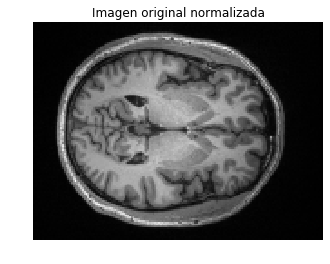

In [8]:
img_gray= a[:,:,128]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)


## 2.Conceptos teóricos algoritmo: Crecimiento por regiones

El crecimiento de regiones se basa en localizar píxeles con intensidades similares según un determinado criterio de homogeneidad.En este caso, partimos de la idea de que la región a segmentar es una región homogénea desde algún punto de vista, y que sea diferente de otras regiones.

El proceso de crecimiento de regiones se inicia seleccionando un determinado píxel (o grupo de ellos) de la zona de interés, denominado semilla (seed), de forma interactiva o automática.En pasos sucesivos, se comparan los píxeles contiguos a la semilla, se añaden a la ROI si cumplen alguna condición de homogeneidad. Este proceso se repite hasta que se recorre toda la imagen.

Para realizar el crecimiento de regiones, hay que tener en cuenta cómo definimos la conectividad o vecindad entre píxeles.En este caso vamos a comparar el píxel inicial con todos sus píxeles adyacentes, hablamos de vecindad a 8.El utilizar un tipo de conectividad u otra puede tener consecuencias en el resultado final, ya que la vecindad a 4 es mucho más restrictiva.Cuanto menor sea la vecindad que vamos a definir, más restrictivo espacialmente será el crecimiento de regiones, es por ello por lo que elegimos una vecindad a 8. 

Por lo tanto, Este método de segmentación usa un conjunto de semillas como parámetro, estas marcaran la zona a segmentar. Uno de los criterios de homogeneidad se basa en introducir un rango de niveles de gris en torno al valor de la semilla, definiendo de tal modo el rango de niveles de gris asociado a la región que marca la semilla.


## 3. Flujo de la función.RegionGrowingP2() creada

Implementamos la función **RegionGrowingP2** del fichero **modules.py**, que tiene como parámetros de entrada la imagen a segmentar, y el rango de gris de la región (umbral_inf y umbral sup).

Para seleccionar la semilla usamos la función **ginput** del paquete matplotlib. 

Una vez marcada la semilla, nos interesa recorrer los puntos de alrededor de la misma, es decir usar conectividad a 8. La conectividad a 8 (Los píxeles están conectados si sus bordes o esquinas se tocan. Dos píxeles adyacentes forman parte del mismo objeto si están encendidos y están conectados a lo largo de la dirección horizontal, vertical o diagonal) y evaluar si sus valores de gris están en torno al valor de la semilla. Para ello, vamos a utilizar los umbrales introducidos en la definición de la función:

    • Si el valor de gris del píxel está dentro del intervalo umbral_inf<seed<umbral_sup, añado esa coordenada a la región y continúo iterando.
    • Si no lo está, no lo añado y continúo iterando.
    
Este algoritmo recursivo finaliza una vez analizado todos los pixeles de nuestra imagen.

## 3. Ejemplo y discusión de los resultados


### Sustancia blanca,gris y negra

In [9]:
%matplotlib auto
regiones = modules.RegionGrowingP2(img_o, 0.3, 0.1)
regiones2 = modules.RegionGrowingP2(img_o, 0.2, 0.1)
regiones3 = modules.RegionGrowingP2(img_o, 0.1, 0.1)

Using matplotlib backend: TkAgg
[76.9025974025974, 65.53896103896102]
[66, 77]
[89.8896103896104, 72.35714285714285]
[72, 90]
[97.03246753246754, 89.88961038961037]
[90, 97]


(Text(0.5, 1.0, 'Sustancia Negra'), (-0.5, 159.5, 119.5, -0.5))

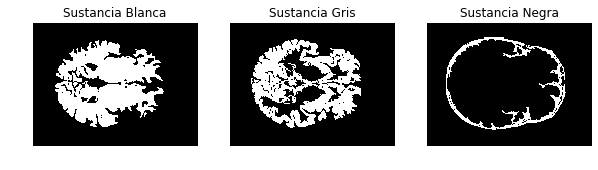

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(regiones, cmap=plt.cm.gray)

plt.title('Sustancia Blanca'), plt.axis('off')
plt.subplot(132)
plt.imshow(regiones2, cmap=plt.cm.gray)

plt.title('Sustancia Gris'), plt.axis('off')

plt.subplot(133)
plt.imshow(regiones3, cmap=plt.cm.gray)

plt.title('Sustancia Negra'), plt.axis('off')

Una región consiste en una parte de la imagen que satisface un cierto criterio de uniformidad. Como podemos observar, cada región comienza a formarse a partir del pixel semilla y va evolucionando, mediante un algoritmo recursivo, por incorporación de aquellos pixeles vecinos a los ya integrados. 

Por tanto seleccionando nuestra semilla, podemos diferenciar distintas regiones de interés como son la sustancia blanca, la sustancia gris y la sustancia negra.





## 4. Referencias


## 5. Autoría
Esta práctica ha sido realizada por **Mariana Nakagawa, María Pardo y Gema Pérez**. Consideramos que las aportaciones de cada una en todos los puntos del trabajo se deben tener en cuenta. Hemos colaborado todas en la elaboración de cada algoritmo y en la solución de problemas.